# **CS 1810 Homework 4**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problem 2 on Homework 4. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.spatial import distance

# Problem 1

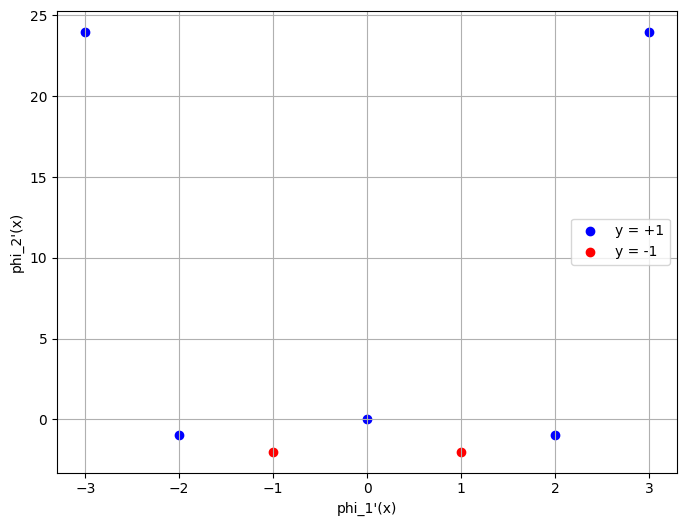

In [120]:
# YOUR CODE HERE
data = [(-3, +1), (-2, +1), (-1, -1), (0, +1), (1, -1), (2, +1), (3, +1)]

def phi(x):
    return np.array([x, (-8/3)*x**2 + (2/3)*x**4])

def phi_prime(x):
    return np.array([x, (-31/12)*x**2 + (7/12)*x**4])

# transformed_points = np.array([phi(x) for x, _ in data])
# labels = np.array([y for _, y in data])

# pos_points = transformed_points[labels == 1]
# neg_points = transformed_points[labels == -1]

# # Plot
# plt.figure(figsize=(8, 6))
# plt.scatter(pos_points[:, 0], pos_points[:, 1], color='blue', label='y = +1')
# plt.scatter(neg_points[:, 0], neg_points[:, 1], color='red', label='y = -1')

# plt.xlabel('phi_1(x)')
# plt.ylabel('phi_2(x)')
# plt.legend(loc = "center right")
# plt.grid(True)
# plt.show()

transformed_points = np.array([phi_prime(x) for x, _ in data])
labels = np.array([y for _, y in data])

pos_points = transformed_points[labels == 1]
neg_points = transformed_points[labels == -1]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pos_points[:, 0], pos_points[:, 1], color='blue', label='y = +1')
plt.scatter(neg_points[:, 0], neg_points[:, 1], color='red', label='y = -1')

plt.xlabel("phi_1'(x)")
plt.ylabel("phi_2'(x)")
plt.legend(loc="center right")
plt.grid(True)
plt.show()

# Problem 2

In [9]:
# Loading datasets

small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [52]:
class KMeans:
    def __init__(self, K):
        self.K = K
        self.centroids = []
        self.objective_hist = []
        self.assignments = []

    def l2norm(self, X, centroids):
        N = X.shape[0]
        distances = np.zeros((N, self.K))
        for i in range(N):
            for k in range(self.K):
                diff = X[i] - centroids[k]
                distances[i, k] = np.sqrt(np.sum(diff ** 2))
        return distances

    def fit(self, X):
        """
        Run the k-Means algorithm for exactly 10 iterations.

        :param X: a (N x 784) array since the dimension of each image is 28x28
        """
        self.centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
        for _ in range(10):
            dist = self.l2norm(X, self.centroids)
            self.assignments = np.argmin(dist, axis=1)
            new_centroids = []
            for k in range(self.K):
                points = X[self.assignments == k]
                if len(points) > 0:
                    new_centroids.append(points.mean(axis=0))
                else:
                    new_centroids.append(X[np.random.choice(X.shape[0])])
            self.centroids = np.vstack(new_centroids)

            obj = np.sum(np.sum((X[self.assignments == k] - self.centroids[k]) ** 2) for k in range(self.K))
            self.objective_hist.append(obj)

    def plot_verify_objective(self):
        """
        This should plot the objective as a function of iteration and verify that it never increases.

        This assumes that fit() has already been called.
        """
        plt.plot(self.objective_hist, marker = "o")
        plt.xlabel('Iter')
        plt.ylabel('Residual Sum of Squares')
        plt.title('Objective Func vs Iterations')
        plt.show()

    def get_mean_images(self):
        """ 
        This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
        """
        return self.centroids

    def get_cluster_sizes(self):
        return np.array([np.sum(self.assignments == k) for k in range(self.K)])


### Part 1

/var/folders/7d/vs4kyt612wv601llgqwwx1yw0000gn/T/ipykernel_15265/3244846059.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj = np.sum(np.sum((X[self.assignments == k] - self.centroids[k]) ** 2) for k in range(self.K))


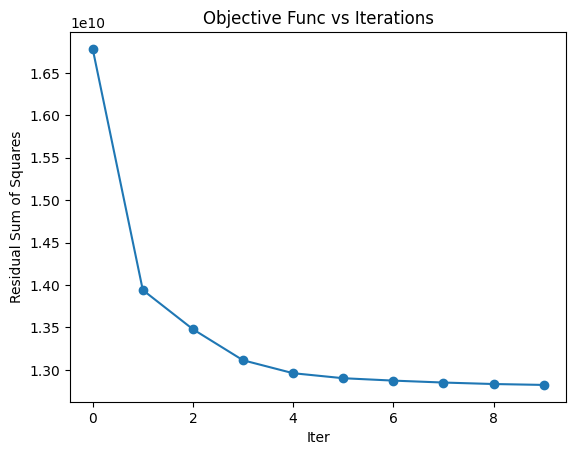

In [53]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

### Code for plots in part 2 and 3

In [54]:
def make_mean_image_plot(data, standardized = False, filename=None):
    niters = 3
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()

### Part 2

/var/folders/7d/vs4kyt612wv601llgqwwx1yw0000gn/T/ipykernel_15265/3244846059.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj = np.sum(np.sum((X[self.assignments == k] - self.centroids[k]) ** 2) for k in range(self.K))


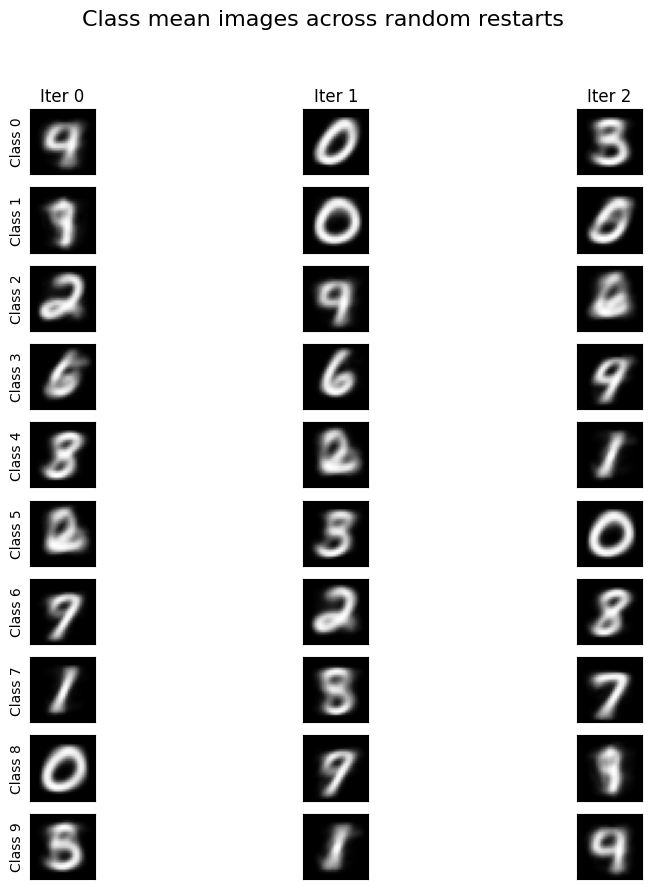

In [56]:
make_mean_image_plot(large_dataset, filename='p2.2.png')

### Part 3

/var/folders/7d/vs4kyt612wv601llgqwwx1yw0000gn/T/ipykernel_15265/3244846059.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj = np.sum(np.sum((X[self.assignments == k] - self.centroids[k]) ** 2) for k in range(self.K))


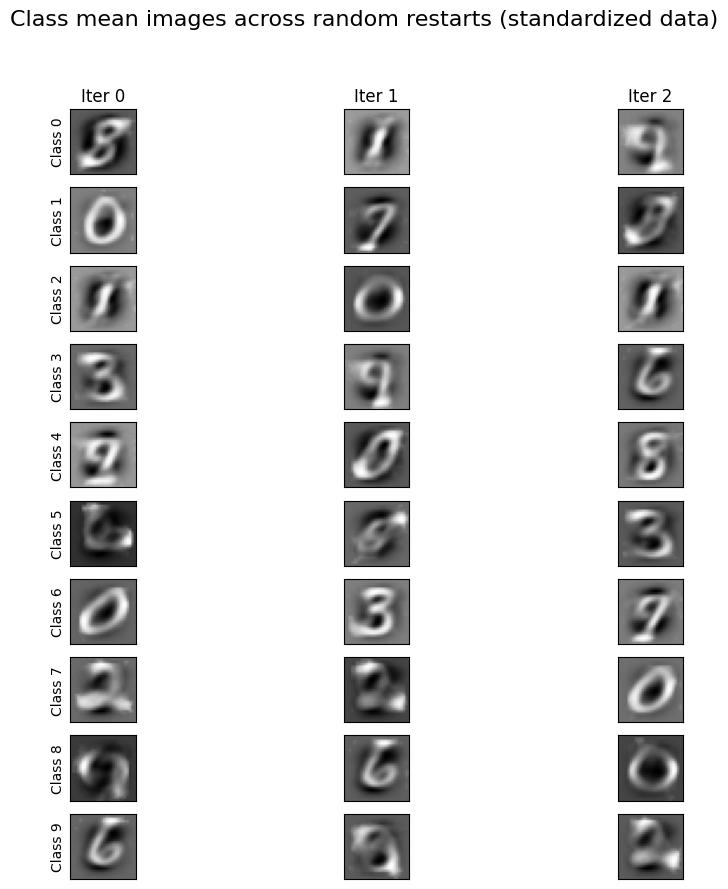

In [76]:
pixel_means = np.mean(large_dataset, axis=0)
pixel_stds = np.std(large_dataset, axis=0)
pixel_stds[pixel_stds == 0] = 1

large_dataset_std = (large_dataset - pixel_means) / pixel_stds

make_mean_image_plot(large_dataset_std, standardized=True, filename='p2.3.png')


## HAC: Part 4


In [165]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.assignments = None
        self.X = None
        self.hist = []

    def link(self, cluster_a, cluster_b):
        if self.linkage == 'max':
            return np.max(distance.cdist(cluster_a, cluster_b, metric='euclidean'))
        elif self.linkage == 'min':
            return np.min(distance.cdist(cluster_a, cluster_b, metric='euclidean'))
        else:
            centroid_a = np.mean(cluster_a, axis=0)
            centroid_b = np.mean(cluster_b, axis=0)
            return distance.cdist([centroid_a], [centroid_b], metric='euclidean')[0, 0]

    def fit(self, X):
        self.X = X
        n = X.shape[0]

        clusters = {i: [X[i]] for i in range(n)}
        memberships = {i: [i] for i in range(n)}
        init_assign = np.arange(n)
        self.hist.append(init_assign.copy())

        while len(clusters) > 1:
            best_dist = np.inf
            best_pair = None
            keys = list(clusters.keys())
            for i in range(len(keys)):
                for j in range(i + 1, len(keys)):
                    id1, id2 = keys[i], keys[j]
                    d = self.link(np.array(clusters[id1]), np.array(clusters[id2]))
                    if d < best_dist:
                        best_dist = d
                        best_pair = (id1, id2)

            low, high = min(best_pair), max(best_pair)
            clusters[low].extend(clusters[high])
            memberships[low].extend(memberships[high])
            del clusters[high]
            del memberships[high]

            new_assign = np.zeros(n)
            for key, indices in memberships.items():
                new_assign[indices] = key
            self.hist.append(new_assign.copy())
        self.assignments = new_assign
        
    # Return assignments when there were K clusters
    def get_k_clusters(self, K):
        for assign in self.hist:
            if len(np.unique(assign)) == K:
                return assign
        return None

    # Get mean images when using K clusters
    def get_mean_images(self, K):
        assign = self.get_k_clusters(K)
        centroids = []
        for label in np.unique(assign):
            centroids.append(np.mean(self.X[assign == label], axis=0))
        return np.array(centroids)

    # Get cluster sizes to compare min and max linkage
    def get_cluster_sizes(self, K):
        assign = self.get_k_clusters(K)
        sizes = []
        for label in np.unique(assign):
            sizes.append(np.sum(assign == label))
        return np.array(sizes)

### Part 4: This takes ~6 minutes to run

Done: max
Done: min
Done: centroid


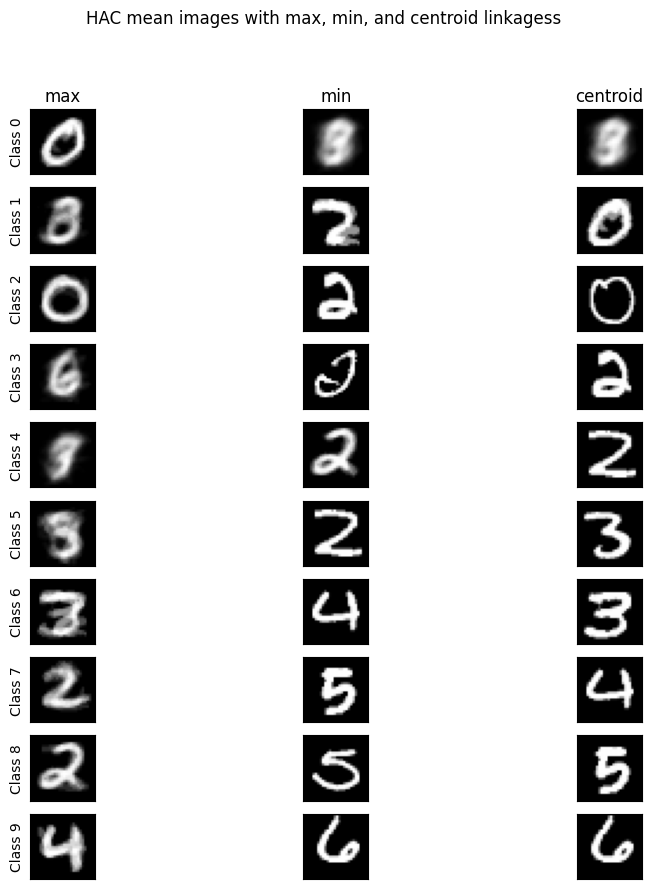

In [166]:
LINKAGES = [ 'max', 'min', 'centroid' ]
n_clusters = 10
cluster_sizes = []

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkagess")
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters)) # used in Part 8, append here to avoid re-fitting
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
    print("Done:", l)
plt.savefig('img_output/p2.4.png') 
plt.show()

### Part 5:

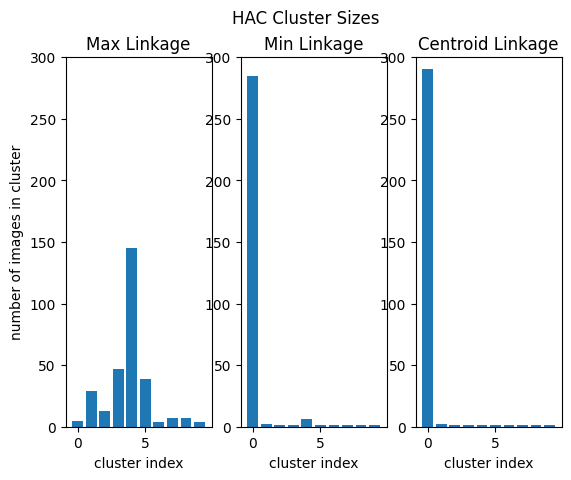

In [167]:
# HAC graphs
def plot_cluster_sizes(n_clusters, cluster_sizes, filename=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes, filename='p2.5a.png')

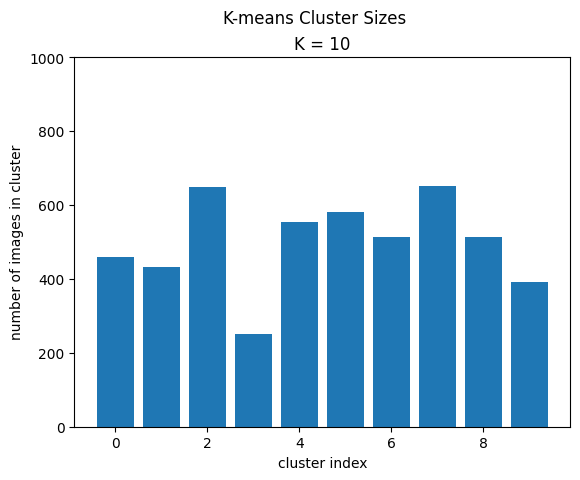

In [168]:
# K-means graphs
def plot_cluster_sizes(n_clusters, cluster_sizes, filename=None):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    if filename:
        plt.savefig(f'img_output/{filename}') 
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes(), filename='p2.5b.png')

### Part 6: Confusion Matrix

/var/folders/7d/vs4kyt612wv601llgqwwx1yw0000gn/T/ipykernel_15265/3244846059.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj = np.sum(np.sum((X[self.assignments == k] - self.centroids[k]) ** 2) for k in range(self.K))


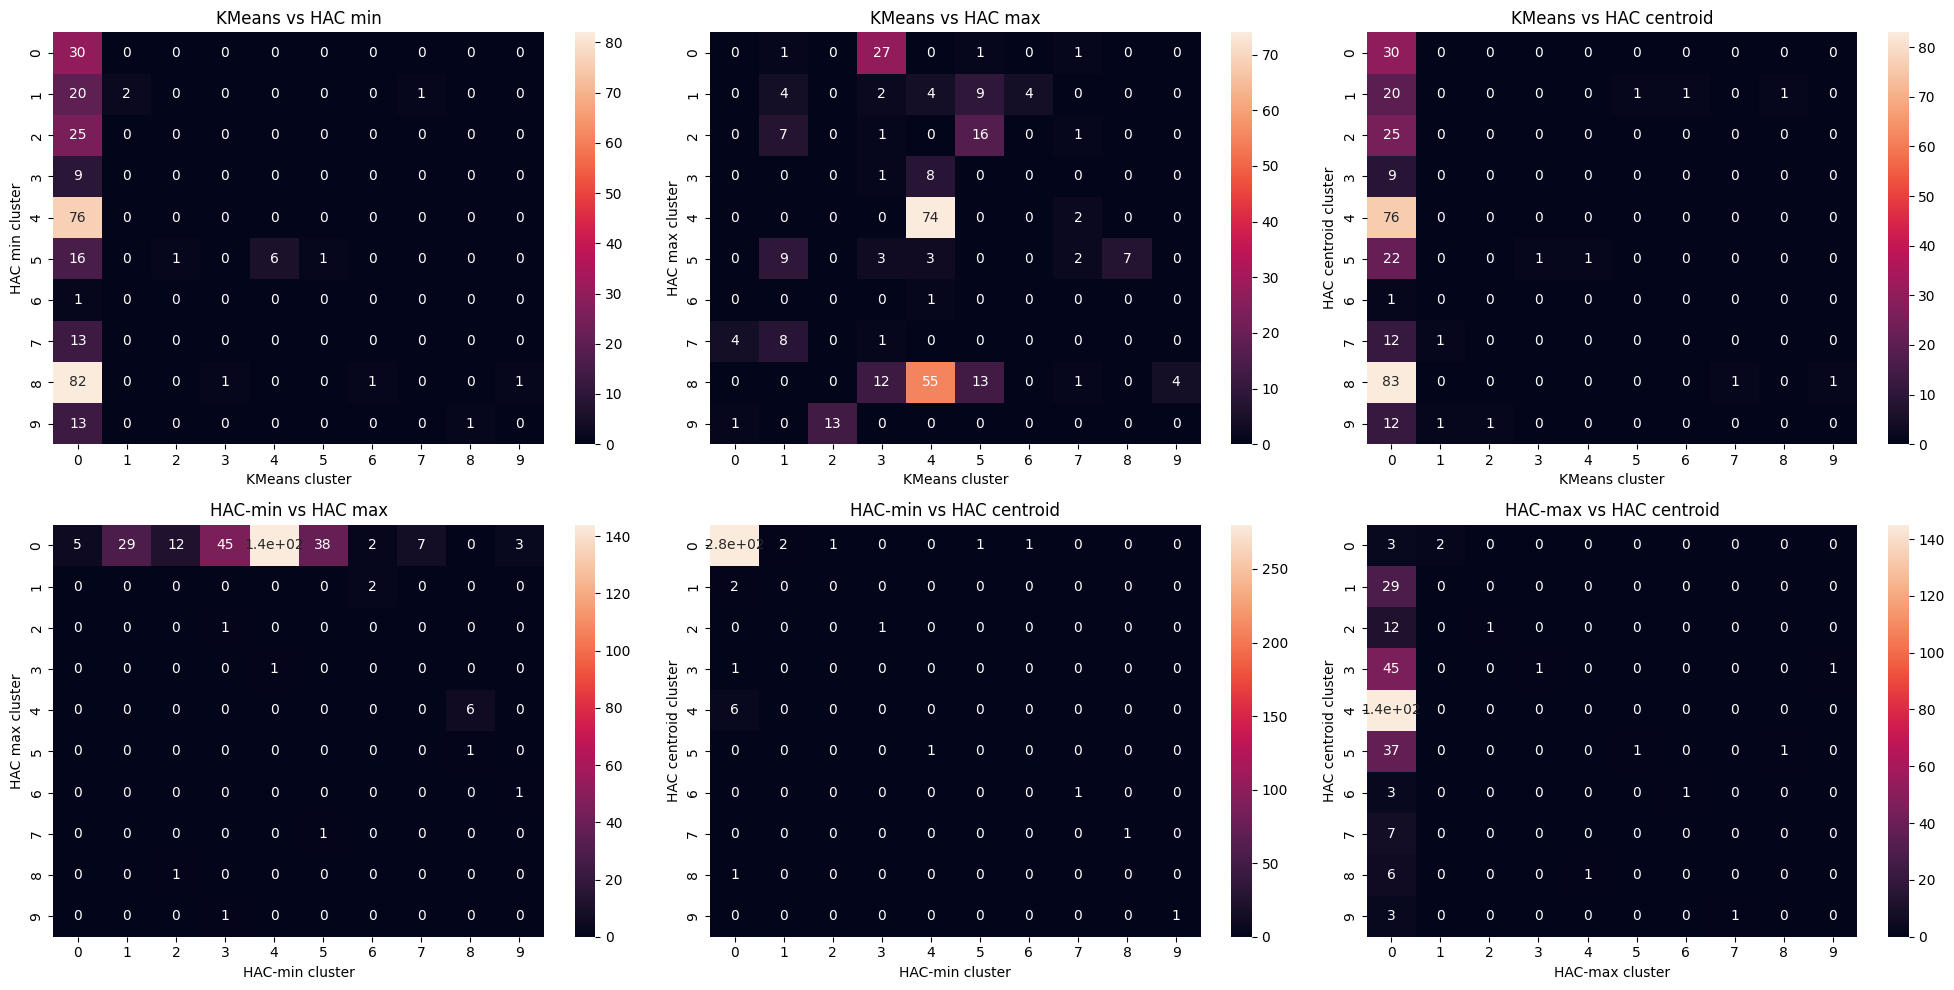

In [192]:
K = 10

km = KMeans(K)
km.fit(small_dataset)
km_assign = km.assignments

hac_min = HAC('min')
hac_min.fit(small_dataset)
hac_min_assign = hac_min.get_k_clusters(K)

hac_max = HAC('max')
hac_max.fit(small_dataset)
hac_max_assign = hac_max.get_k_clusters(K)

hac_cent = HAC('centroid')
hac_cent.fit(small_dataset)
hac_cent_assign = hac_cent.get_k_clusters(K)

def compute_confusion_matrix(assign1, assign2):
    unique1 = np.unique(assign1)
    unique2 = np.unique(assign2)
    conf = np.zeros((len(unique2), len(unique1)), dtype=int)
    
    for i, c1 in enumerate(unique1):
        for j, c2 in enumerate(unique2):
            conf[i, j] = np.sum((assign1 == c1) & (assign2 == c2))

            
    return conf, unique1, unique2

pairs = [
    ("KMeans vs HAC min",        km_assign,      hac_min_assign,     "KMeans",  "HAC min"),
    ("KMeans vs HAC max",        km_assign,      hac_max_assign,     "KMeans",  "HAC max"),
    ("KMeans vs HAC centroid",   km_assign,      hac_cent_assign,    "KMeans",  "HAC centroid"),
    ("HAC-min vs HAC max",       hac_min_assign, hac_max_assign,     "HAC-min", "HAC max"),
    ("HAC-min vs HAC centroid",  hac_min_assign, hac_cent_assign,    "HAC-min", "HAC centroid"),
    ("HAC-max vs HAC centroid",  hac_max_assign, hac_cent_assign,    "HAC-max", "HAC centroid"),
]

fig, axs = plt.subplots(2,3, figsize=(20, 10))

for idx, (title, a1, a2, nameA, nameB) in enumerate(pairs):
    r = idx // 3
    c = idx % 3
    
    conf, unique1, unique2 = compute_confusion_matrix(a1, a2)
    ax = axs[r, c]
    heatmap(conf, annot=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(f'{nameA} cluster')
    ax.set_ylabel(f'{nameB} cluster')

plt.tight_layout()
plt.show()